In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.optimizers import Adam

In [4]:
mpl.rcParams['figure.figsize'] = (20, 6)  # Width, Height in inches
plt.figure(figsize=(25, 6))

<Figure size 2500x600 with 0 Axes>

<Figure size 2500x600 with 0 Axes>

In [7]:
def preprocess_data_v2():
    file_name = "port_ray.xlsx"
    df = pd.read_excel(file_name)

    return df

In [8]:
df = preprocess_data_v2()
df.columns.values[1] = 'Return'

df.head(10)

,Date,Return
0,2017-08-07,0.0
1,2017-08-08,-32070.0
2,2017-08-09,14990.0
3,2017-08-10,-7280.0
4,2017-08-11,38710.0
5,2017-08-14,-102220.0
6,2017-08-15,36030.0
7,2017-08-16,-52910.0
8,2017-08-17,-39340.0
9,2017-08-18,12560.0


In [9]:
def plot_return():
    # Plot the volatility
    plt.plot(df['Date'], df['Return'], label='Return', linestyle='--', color='orange')

    plt.title('Return Plot')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    # plt.show()

    plt.savefig('return.jpg')

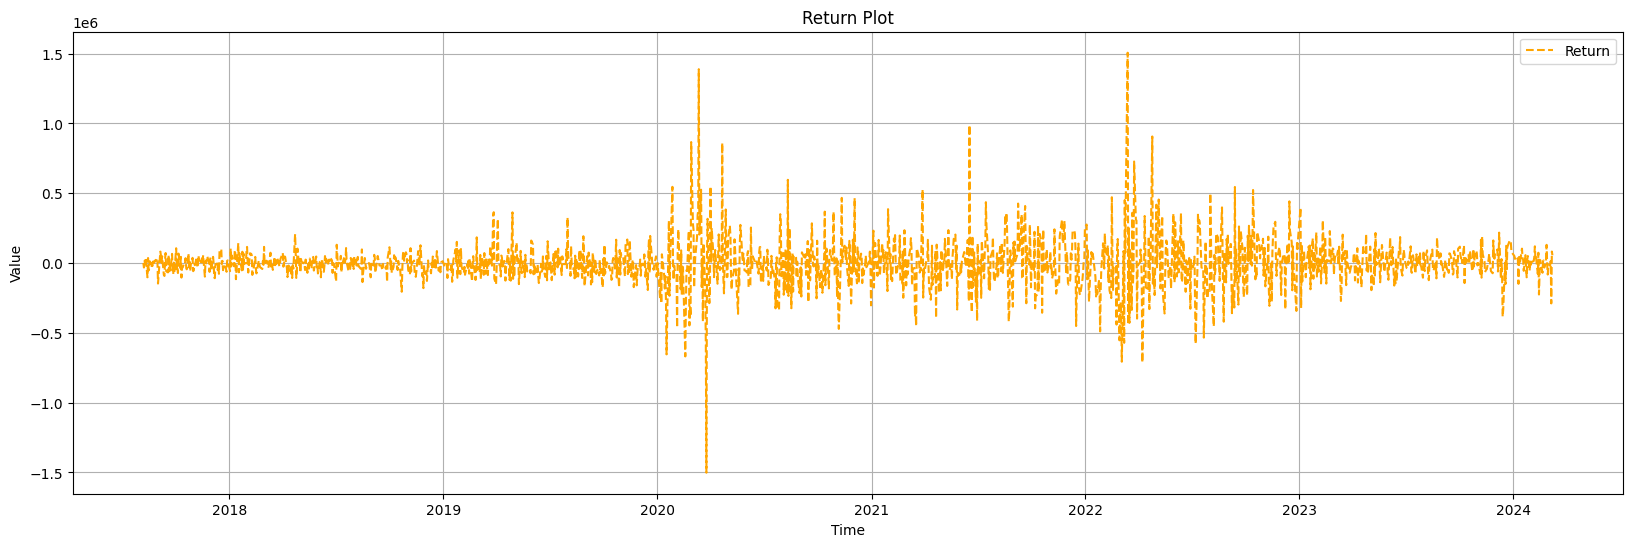

In [10]:
plot_return()

In [11]:
# Windowing: Creating sequences/windows
sequence_length = 5  # which is the rolling window dates

def prep_seqdata_for_model(dfrme):
    sequences = []
    size = len(dfrme)

    if (size == sequence_length):
        return np.array(dfrme)

    for i in range(size - sequence_length):
        sequences.append(dfrme[i:i+sequence_length])
    sequences = np.array(sequences)

    return sequences


In [12]:
sequences = prep_seqdata_for_model(df['Return'])

In [13]:
# Split data into train and validation sets
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
val_data = sequences[train_size:]

In [14]:
# Define the autoencoder model
num_features = 1

model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(num_features))
])

# custom_learning_rate = 0.00001  # Adjust this value as needed
# adam_optimizer = Adam(learning_rate=custom_learning_rate)

In [69]:
model.compile(optimizer='adam', loss='mse')

# Training the autoencoder
model.fit(train_data, train_data, epochs=2500, batch_size=32, validation_data=(val_data, val_data))


Epoch 1/2500
42/42 [==============================] - 6s 25ms/step - loss: 13862718464.0000 - val_loss: 6195672064.0000
Epoch 2/2500
42/42 [==============================] - 0s 9ms/step - loss: 11710683136.0000 - val_loss: 5396501504.0000
Epoch 3/2500
42/42 [==============================] - 0s 9ms/step - loss: 11859542016.0000 - val_loss: 5993093632.0000
Epoch 4/2500
42/42 [==============================] - 0s 9ms/step - loss: 10904329216.0000 - val_loss: 5206532096.0000
Epoch 5/2500
42/42 [==============================] - 0s 10ms/step - loss: 10662270976.0000 - val_loss: 4803352576.0000
Epoch 6/2500
42/42 [==============================] - 0s 9ms/step - loss: 9114675200.0000 - val_loss: 4766330880.0000
Epoch 7/2500
42/42 [==============================] - 0s 9ms/step - loss: 8479444480.0000 - val_loss: 4850949632.0000
Epoch 8/2500
42/42 [==============================] - 0s 9ms/step - loss: 8977230848.0000 - val_loss: 4565060608.0000
Epoch 9/2500
42/42 [=============================

In [70]:
# save model
from tensorflow.keras.models import save_model, load_model

# Assuming autoencoder_model is your trained model
model.save('cpd_model_.h5')


In [71]:
# load model for test
cpd_model = load_model('cpd_model_.h5')

In [72]:
def classify_volatility(volatility, low_threshold, medium_threshold):
    return 'High' if volatility >= medium_threshold else \
           'Medium' if volatility >= low_threshold else 'Low'

In [73]:
def predict_volatility():
    # predict today's regime
    last_record = val_data[-1]
    reshaped_data = np.expand_dims(last_record, axis=0).reshape((1,) + last_record.shape)
    x = cpd_model.predict(reshaped_data)

    pred_volatility = x[0][4][0]

    return pred_volatility

In [74]:
pred_volatility = predict_volatility()

In [75]:
# Reconstruction of validation data
predicted_data = cpd_model.predict(sequences)

# Calculating reconstruction loss
# remove extra dimension from predicted_va_data
predicted_data = predicted_data.squeeze(axis=-1)
reconstruction_losses = np.mean(np.square(sequences - predicted_data), axis=(1, ))

# MSE
mse = np.mean((sequences - predicted_data) ** 2)
rmse = np.sqrt(mse)

print(f"mse: {mse} \nrmse: {rmse}")


# Define a threshold for detecting regime changes
# Calculate mean and standard deviation of reconstruction errors on validation set
error_mean = np.mean(reconstruction_losses)
error_std = np.std(reconstruction_losses)

# Set threshold as a multiple of standard deviation above the mean error
threshold = error_mean + error_std/2

print(f"error_mean {error_mean}\nerror_std {error_std}\nthreshold {threshold}")

# Detect regime changes based on the threshold for validation dataset
regime_change_indices = np.where(reconstruction_losses > threshold)[0]
regime_change_indices

all_regime_change_indices = regime_change_indices

print(f'\nTotal Change Points: {len(all_regime_change_indices)}')

mse: 479345438.519958 
rmse: 21893.958950357926
error_mean 479345438.5199581
error_std 1054792614.5249814
threshold 1006741745.7824488

Total Change Points: 196


In [76]:
# Reshape the 3D array to 2D, dropping the middle dimension
reshaped_data = predicted_data.reshape(-1, predicted_data.shape[-1])

# Convert the 2D NumPy array to a DataFrame
df_pred = pd.DataFrame(reshaped_data)
df_pred['Date'] = df['Date']  # 's' for seconds, 'ms' for milliseconds


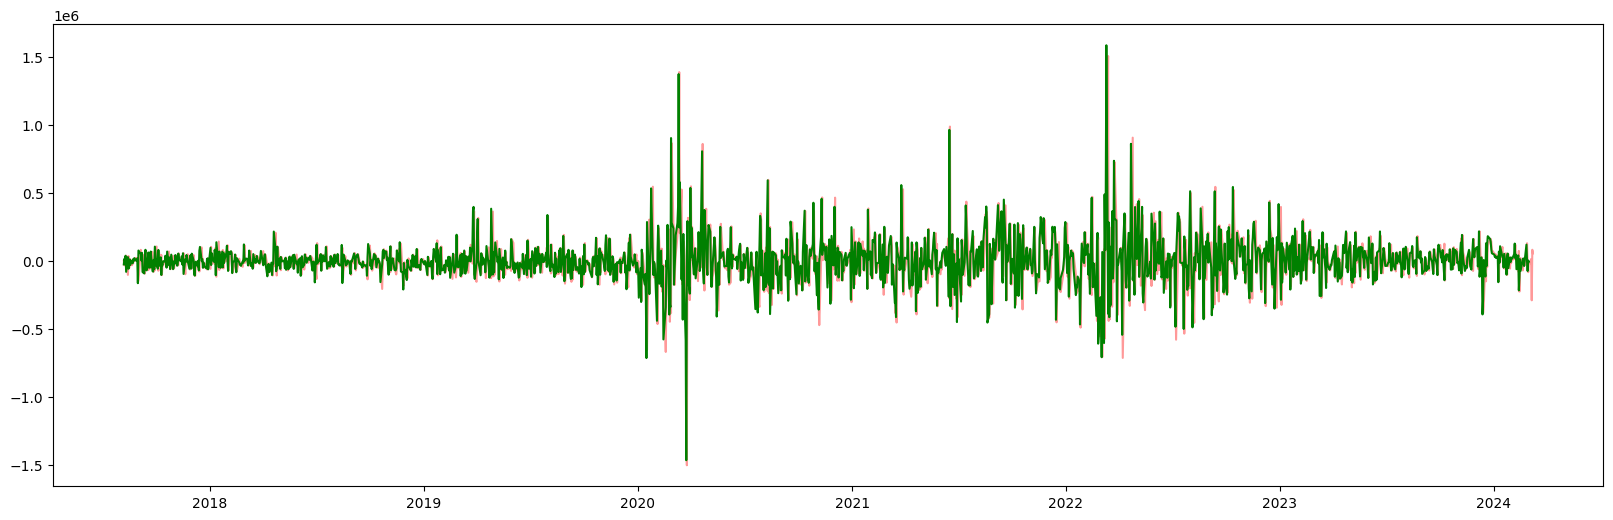

In [77]:
# Plot the data and change points
# plt.plot(df_pred['Date'], df_pred[0], label='Volatility', color="gray")
plt.plot(df_pred['Date'], df_pred[1], label='Return', color="green", zorder = 3)

plt.plot(df['Date'], df['Return'], color='red', alpha = 0.4)

In [78]:
# group change points
from sklearn.cluster import DBSCAN
# Reshape the data for DBSCAN (needed for sklearn)
X = all_regime_change_indices.reshape(-1, 1)

# DBSCAN parameters
epsilon = sequence_length * 8 # Maximum distance between points to be considered in the same neighborhood
min_samples = sequence_length * 3  # Minimum number of samples in a neighborhood

In [79]:
# DBSCAN clustering
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(X)

# Getting cluster labels and core sample indices
cluster_labels = dbscan.labels_
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

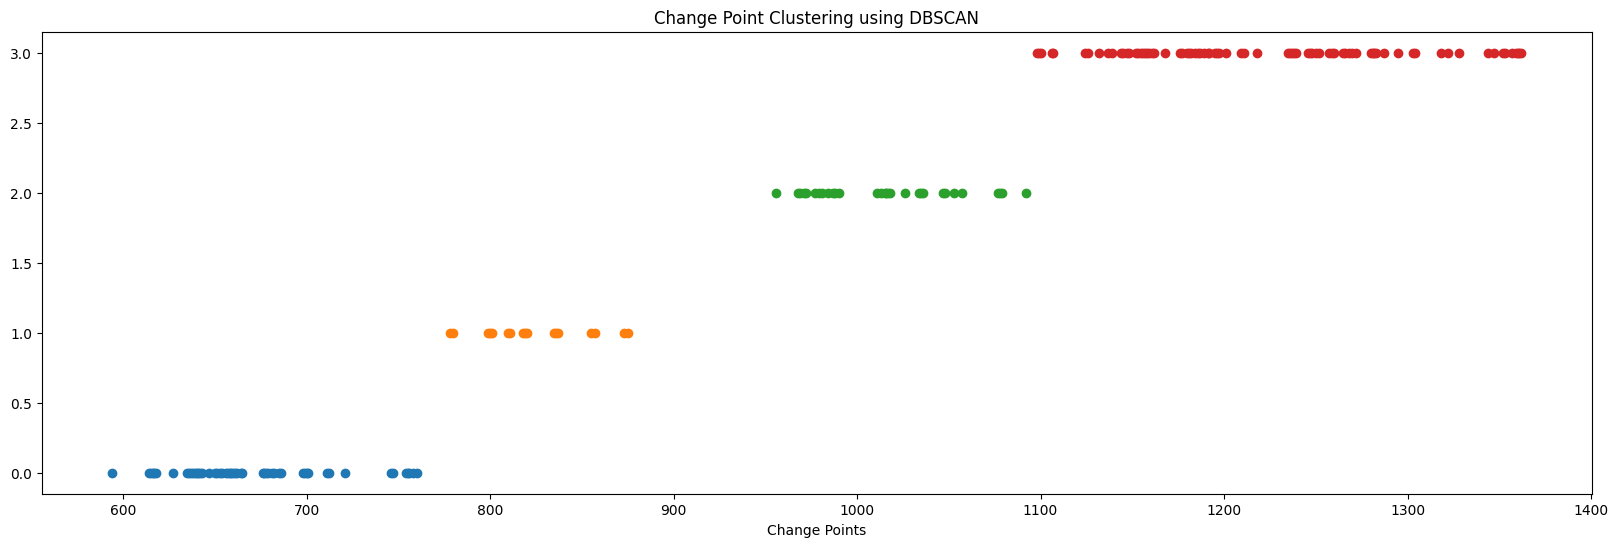

Cluster 0: Change Points - [array([594, 614, 615, 616, 617, 618, 627, 635, 636, 637, 638, 639, 640,
       641, 642, 643, 647, 650, 651, 653, 654, 656, 657, 658, 659, 660,
       661, 662, 664, 665, 676, 677, 678, 679, 681, 682, 685, 686, 698,
       699, 700, 701, 711, 712, 721, 746, 747, 754, 755, 756, 758, 760],
      dtype=int64)]
Cluster 1: Change Points - [array([778, 780, 799, 800, 801, 810, 811, 818, 819, 820, 835, 836, 837,
       855, 857, 873, 875], dtype=int64)]
Cluster 2: Change Points - [array([ 956,  968,  969,  971,  972,  977,  979,  981,  984,  987,  988,
        990, 1011, 1013, 1015, 1016, 1017, 1018, 1026, 1034, 1035, 1036,
       1047, 1048, 1053, 1057, 1077, 1078, 1079, 1092], dtype=int64)]
Cluster 3: Change Points - [array([1098, 1099, 1100, 1106, 1107, 1124, 1126, 1132, 1137, 1139, 1144,
       1145, 1147, 1148, 1152, 1153, 1155, 1156, 1157, 1158, 1159, 1161,
       1162, 1168, 1176, 1177, 1180, 1181, 1182, 1184, 1186, 1187, 1189,
       1191, 1192, 1195, 1196,

In [80]:
from collections import defaultdict

# Extracting unique clusters and their indices
unique_labels = set(cluster_labels)
cluster_change_points = defaultdict(list)

if -1 in unique_labels:
    unique_labels.remove(-1)  # Remove noise label (-1)


for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    cluster_change_points[label].append(cluster_points)
    plt.plot(cluster_points, np.ones_like(cluster_points) * label, 'o', label=f'Cluster {label}')

plt.xlabel('Change Points')
plt.title('Change Point Clustering using DBSCAN')
# plt.legend()
plt.show()

# Print or process cluster-wise change points
for cluster, points in cluster_change_points.items():
    print(f"Cluster {cluster}: Change Points - {points}")

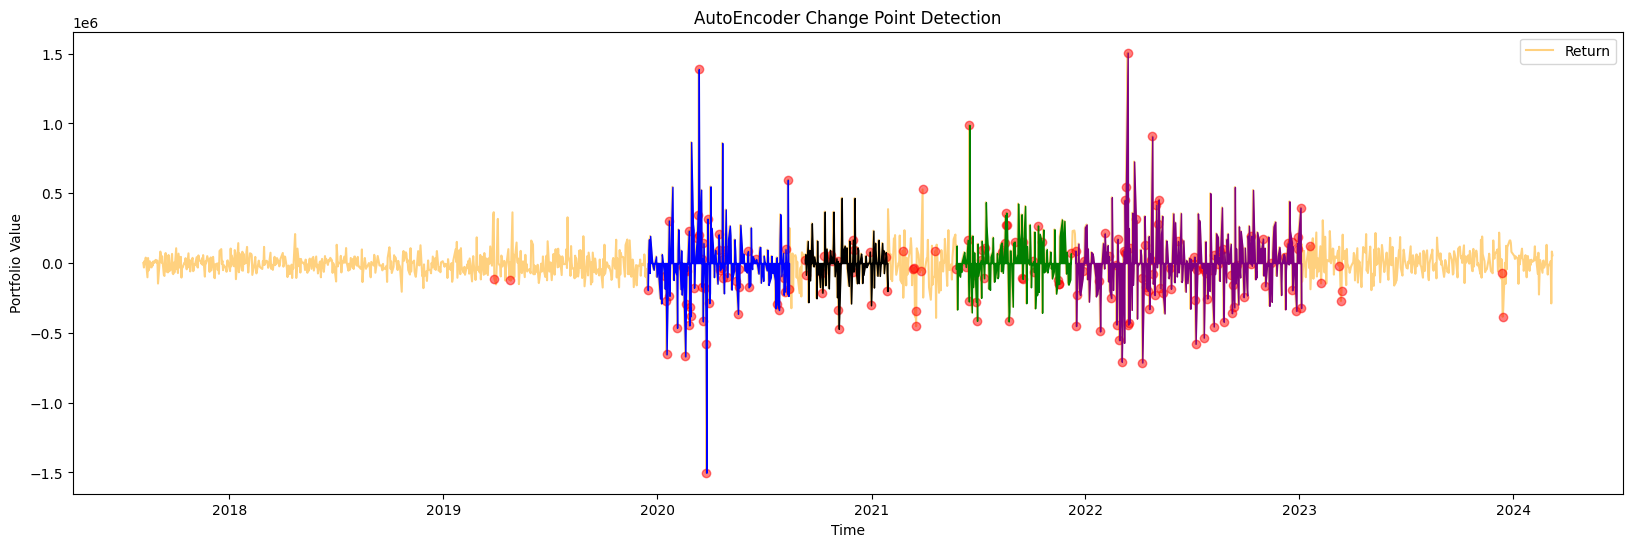

In [83]:
# Plot the data and change points
# plt.plot(df['Date'], df['Portfolio_Value'], label='Portfolio_Value', color="orange")
plt.plot(df['Date'], df['Return'], label='Return', color="orange", alpha = 0.5)


# Mark the change points on the chart
for change_point in all_regime_change_indices:
    plt.scatter(df['Date'].iloc[change_point], df['Return'].iloc[change_point], marker='o', color='red', zorder=2, alpha=0.5)

colors = ['blue', 'black', 'green', 'purple' ]  # Define custom colors

for i, (cluster, points) in enumerate(cluster_change_points.items()):
    color = colors[i % len(colors)]
    index_range = points[0]

    start_index = index_range[0]
    end_index = index_range[len(index_range) -1]

    plt.fill_between(df['Date'][start_index:end_index+1], df['Return'][start_index:end_index+1], color = color, zorder=3, alpha=1)

plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title('AutoEncoder Change Point Detection')
plt.legend()

# the above figure shall be saved and then served
plt.savefig('regime.png')

In [68]:
# Gather recent 5 day's record
last_5_records = sequences[-5:]

reconstructed_data = cpd_model.predict(last_5_records)
reconstruction_error = np.mean(np.square(last_5_records - reconstructed_data), axis=1)

if reconstruction_error.any() > threshold:
    print("Regime change predicted for today!")
else:
    print("No regime change predicted for today.")
    # output current regime (low - medium - high volativlity)


No regime change predicted for today.
